<a href="https://colab.research.google.com/github/tomik062/AI_Project/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

extract data from github and merge together

In [7]:
import requests
import os
import importlib.util
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV, LeaveOneOut,KFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso,ElasticNet
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Define the GitHub details
def init_process():
  repo_owner = 'tomik062'
  repo_name = 'AI_Project'
  file_path = 'extract_data.py'
  url = f'https://raw.githubusercontent.com/{repo_owner}/{repo_name}/main/{file_path}'

  # Directory to save the downloaded file
  download_dir = 'data_extraction_code'
  if not os.path.exists(download_dir):
      os.makedirs(download_dir)

  local_file_path = os.path.join(download_dir, file_path)

  # Download the file
  response = requests.get(url)
  response.raise_for_status() # Raise an exception for bad status codes

  with open(local_file_path, 'wb') as f:
      f.write(response.content)

  print(f"Downloaded {file_path} to {local_file_path}")

  # Import the function from the downloaded file
  spec = importlib.util.spec_from_file_location("extract_data_module", local_file_path)
  module = importlib.util.module_from_spec(spec)
  spec.loader.exec_module(module)
  # Call the extract_data function and print the output
  return module.extract_data()

In [8]:
def calc_features_year(data,year):
    feature_map = {
        'urbanization': 0,
        'avg birth age': 1,
        'happiness': 2,
        'health expenditure': 3,
        'physicians per capita': 4,
        'GNI PPP': 5,
        'female labor participation': 6,
        'christians': 7,
        'muslims': 8,
        'no religion': 9,
        'buddhists': 10,
        'hindus': 11,
        'jews': 12,
        'other religion': 13,
        'in Asia-Pacific':14,
        'in Europe':15,
        'in Latin America-Caribbean':16,
        'in Middle East-North Africa':17,
        'in North America':18,
        'in Sub-Saharan Africa':19,
        'education man': 20,
        'education women': 21,
        'hdi': 22,
        'gii': 23,
        'avg marriage age women': 24,
        'avg marriage age men': 25,
        'maternity leave index': 26,
        'work hours men': 27,
        'work hours women': 28,
        'abortions': 29,
        'social media users': 30
    }
    countries = sorted(list(set([key[0] for key in data.keys()])))
    df = pd.DataFrame(index=countries, columns=feature_map.keys())
    target=[]
    # Populate the DataFrame
    for country in countries:
        key = (country, year)
        if key in data:
            features = data[key][1]
            target.append(data[key][0])
            for feature_name, feature_index in feature_map.items():
                if feature_index < len(features):
                  df.loc[country, feature_name] = features[feature_index]
                  if str(features[feature_index]) =='nan':
                    df.loc[country, feature_name]=handle_missing_values(data,feature_index,country,year)
    return df,target



def handle_missing_values(data, feature_index, country, year):
    # try taking the value from the last 3 years
    for i in range(1, 4):
        past_year = year - i
        if (country, past_year) in data:
            past_data = data[(country, past_year)][1] # Access the list of features
            if feature_index < len(past_data) and str(past_data[feature_index])!='nan':
                return past_data[feature_index]

    # otherwise if missing last 3 years, linearly extrapulate from last decade
    recent_years_data = []
    for i in range(10,0,-1):
        past_year = year - i
        if (country, past_year) in data:
            past_data = data[(country, past_year)][1] # Access the list of features
            if feature_index < len(past_data) and not pd.isna(past_data[feature_index]):
                 recent_years_data.append((past_year, past_data[feature_index]))

    if len(recent_years_data) >= 2:
        years = [item[0] for item in recent_years_data]
        values = [item[1] for item in recent_years_data]
        # Linear extrapolation using linear regression with polyfit
        try:
            m, c = np.polyfit(years, values, 1)
            extrapolated_value = m * year + c
            return extrapolated_value
        except np.linalg.LinAlgError:
            # Handle cases where polyfit fails (e.g., all years are the same)
            return values[-1] # Return the last known value
    elif len(recent_years_data) == 1:
         # If only one data point in the last 10 years, use that value
         return recent_years_data[0][1]

    # If still missing after checking last 10 years, return NaN
    return np.nan

In [9]:
def find_missing_features(df_features):

  # Identify countries with and without NaN values
  countries_with_nan = df_features[df_features.isnull().any(axis=1)].index.tolist()
  countries_without_nan = df_features.dropna().index.tolist()
  countries_with_one_nan = df_features[df_features.isnull().sum(axis=1) == 1].index.tolist()

  # Print the results
  print("Countries with NaN values in their features:")
  print(countries_with_nan)
  print("\nCountries without NaN values in their features:")
  print(countries_without_nan)
  print("\nCountries with exactly one NaN value in their features:")
  print(countries_with_one_nan)

  print(f"\nNumber of countries with NaN values: {len(countries_with_nan)}")
  print(f"Number of countries without NaN values: {len(countries_without_nan)}")
  print(f"Number of countries with exactly one NaN value: {len(countries_with_one_nan)}")

  # Group countries by their single missing feature
  missing_features_grouped = {}
  if countries_with_one_nan:
      for country in countries_with_one_nan:
          missing_feature_name = df_features.loc[country].isnull().idxmax()
          if missing_feature_name not in missing_features_grouped:
              missing_features_grouped[missing_feature_name] = []
          missing_features_grouped[missing_feature_name].append(country)

      # Print countries grouped by missing feature
      print("\nMissing feature for countries with exactly one NaN:")
      for feature, countries in missing_features_grouped.items():
          print(f"  Missing feature is '{feature}':")
          print(f"    Countries: {', '.join(countries)}")

process 2023 data:
add some missing data, split to train and test and normalize

In [10]:
def process_2023_data(data_output):
    df_features, target = calc_features_year(data_output, 2023)
    missing_values_to_fill = {
        'abortions': {
            'Cyprus': 7,'Ireland': 6.7,'Malaysia': 11,
            'Mauritania': 42,'Malta': 3,'Morocco': 25, 'Congo, Rep.': 39
        },
        'maternity leave index': {
            'Albania': 23.23,'Bosnia and Herzegovina': 52.14,
            'Kazakhstan': 18,'Georgia': 7.59,'Kyrgyz Republic': 18,
            'Moldova': 18,'Angola': 13,'Armenia': 20,
            'Azerbaijan': 18,'Malawi': 12.86,'Bhutan': 8,
            'Tanzania': 12,'Tajikistan': 20,'North Macedonia': 39,
            'Liberia': 12.86,'Suriname': 0,'Uzbekistan': 18
        },
        'gii':{
            'Central African Republic':0.682
        }
    }

    # Fill in missing values using the dictionary
    for feature, country_values in missing_values_to_fill.items():
        for country, value in country_values.items():
            if country in df_features.index:
                df_features.loc[country, feature] = value


    # Create a DataFrame for the target variable
    y = pd.Series(target, index=df_features.index, name='target')

    # Combine features and target into a single DataFrame for easier NaN handling
    combined_df = pd.concat([df_features, y], axis=1)

    # Remove rows with NaN values
    combined_df_cleaned = combined_df.dropna()

    # Separate features and target again
    X = combined_df_cleaned.drop('target', axis=1)
    y = combined_df_cleaned['target']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

In [11]:
def plot_features(X_train):

  # Get the list of columns
  columns = X_train.columns

  # Calculate the number of rows needed
  n_cols = 6
  n_rows = math.ceil(len(columns) / n_cols)

  # Create subplots
  fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
  axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

  # Plot histograms for all features
  for i, column in enumerate(columns):
      axes[i].hist(X_train[column], bins=10)
      axes[i].set_title(f'Histogram of {column}')
      axes[i].set_xlabel(column)
      axes[i].set_ylabel('Frequency')
      axes[i].grid(True)

  # Hide any unused subplots
  for j in range(i + 1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()

In [15]:
def scaling_2023(X_train, X_test):
    # Create copies to avoid modifying the original DataFrames
    X_train = X_train.copy()
    X_test = X_test.copy()
    X_train,X_test = create_health_index_score(X_train,X_test)
    log_features = ['no religion', 'other religion', 'buddhists', 'hindus', 'jews','GNI PPP']
    for feature in log_features:
        X_train[feature] = pd.to_numeric(X_train[feature])
        X_test[feature] = pd.to_numeric(X_test[feature])
        # Apply log1p transformation
        X_train[feature] = np.log1p(X_train[feature])
        X_test[feature] = np.log1p(X_test[feature])

    # Standard scale all features except region features
    features_to_scale = [
        'urbanization', 'avg birth age', 'happiness', 'GNI PPP',
        'female labor participation', 'christians', 'muslims', 'no religion',
        'buddhists', 'hindus', 'jews', 'other religion', 'education man',
        'education women', 'hdi', 'gii', 'avg marriage age women',
        'avg marriage age men', 'maternity leave index', 'work hours men',
        'work hours women', 'abortions', 'social media users',
        'healthcare index score'
    ]

    scaler = StandardScaler()
    X_train[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
    X_test[features_to_scale] = scaler.transform(X_test[features_to_scale])

    # Create 'healthcare index score'

    return X_train, X_test
def create_health_index_score(X_train,X_test):
    scaler_healthcare = StandardScaler()
    health_features = ['physicians per capita','health expenditure']
    X_train[health_features] = scaler_healthcare.fit_transform(X_train[health_features])
    X_test[health_features] = scaler_healthcare.transform(X_test[health_features])
    X_train['healthcare index score'] = X_train['physicians per capita'] + X_train['health expenditure']
    X_test['healthcare index score'] = X_test['physicians per capita'] + X_test['health expenditure']
    X_train = X_train.drop(['physicians per capita', 'health expenditure'], axis=1)
    X_test = X_test.drop(['physicians per capita', 'health expenditure'], axis=1)
    return X_train,X_test


In [3]:
def feature_correlations(df, method):
    """Calculates and visualizes correlation matrix, and prints top 5 correlated pairs."""

    correlation_matrix = df.corr(method=method)

    plt.figure(figsize=(18, 15))
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
    plt.title(f'{method.capitalize()} Correlation Heatmap of Features in X_train')
    plt.show()

    print(f"\nTop 5 most highly correlated pairs of features (absolute {method.capitalize()} correlation):")
    upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    stacked_corr = upper_tri.stack().sort_values(ascending=False, key=abs)
    top_5_correlated_pairs = stacked_corr.head(5)

    if top_5_correlated_pairs.empty:
        print("No correlated pairs found.")
    else:
        for (feature1, feature2), correlation in top_5_correlated_pairs.items():
            print(f"  {feature1} and {feature2}: {correlation:.4f}")


In [4]:
def analyze_target_correlation(X, y, method_name):
    combined_data = pd.concat([X, y], axis=1)
    correlation_series = combined_data.corr(method=method_name)['target'].drop('target').sort_values(ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x=correlation_series.values, y=correlation_series.index, palette='coolwarm')
    plt.title(f'{method_name} Correlation of Features with Target Variable')
    plt.xlabel(f'{method_name} Correlation Coefficient')
    plt.ylabel('Features')
    plt.show()

    print(f"\n{method_name} Correlation with Target:")
    print(correlation_series)


In [5]:
def analyze_mutual_information(X, y):
    """Calculates and displays Mutual Information scores of features with the target."""
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)

    print("Mutual Information Scores of Features with Target Variable:")
    print(mi_scores)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=mi_scores.values, y=mi_scores.index, palette='viridis')
    plt.title('Mutual Information Scores of Features with Target Variable')
    plt.xlabel('Mutual Information Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()

In [10]:
def gridsearch_loocv_lasso(X, y):
    lasso = Lasso()
    loo = LeaveOneOut()
    param_grid = {'alpha': [val * (10**i) for i in range(-12, 4) for val in [1, 2, 5]]}
    grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid,
                               cv=loo, scoring='neg_mean_squared_error',
                               n_jobs=-1)
    grid_search.fit(X, y)
    return grid_search

def gridsearch_elastic_net_loocv(X, y):
    elastic_net = ElasticNet()
    loo = LeaveOneOut()
    param_grid = {'alpha': [val * (10**i) for i in range(-6, 2) for val in [1, 2, 5]],
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99,0.995, 1.0]
    }

    grid_search = GridSearchCV(estimator=elastic_net, param_grid=param_grid,
                               cv=loo, scoring='neg_mean_squared_error',
                               n_jobs=-1)
    grid_search.fit(X, y)
    return grid_search

Downloaded extract_data.py to data_extraction_code/extract_data.py
Downloaded GNI_PPP_const_2021_dollars.csv to data/GNI_PPP_const_2021_dollars.csv
Downloaded Religious-Composition-percentages.csv to data/Religious-Composition-percentages.csv
Downloaded abortion-rates-by-country-2025.csv to data/abortion-rates-by-country-2025.csv
Downloaded age-at-first-marriage-by-country-2025.csv to data/age-at-first-marriage-by-country-2025.csv
Downloaded average-workweek-by-country-2025.csv to data/average-workweek-by-country-2025.csv
Downloaded female-labor-force-participation-rates-slopes.csv to data/female-labor-force-participation-rates-slopes.csv
Downloaded female-labor-participation.csv to data/female-labor-participation.csv
Downloaded gender-inequality-index.xlsx to data/gender-inequality-index.xlsx
Downloaded happiness-cantril-ladder.csv to data/happiness-cantril-ladder.csv
Downloaded healthcare-expenditure-per-capita-ppp.csv to data/healthcare-expenditure-per-capita-ppp.csv
Downloaded high

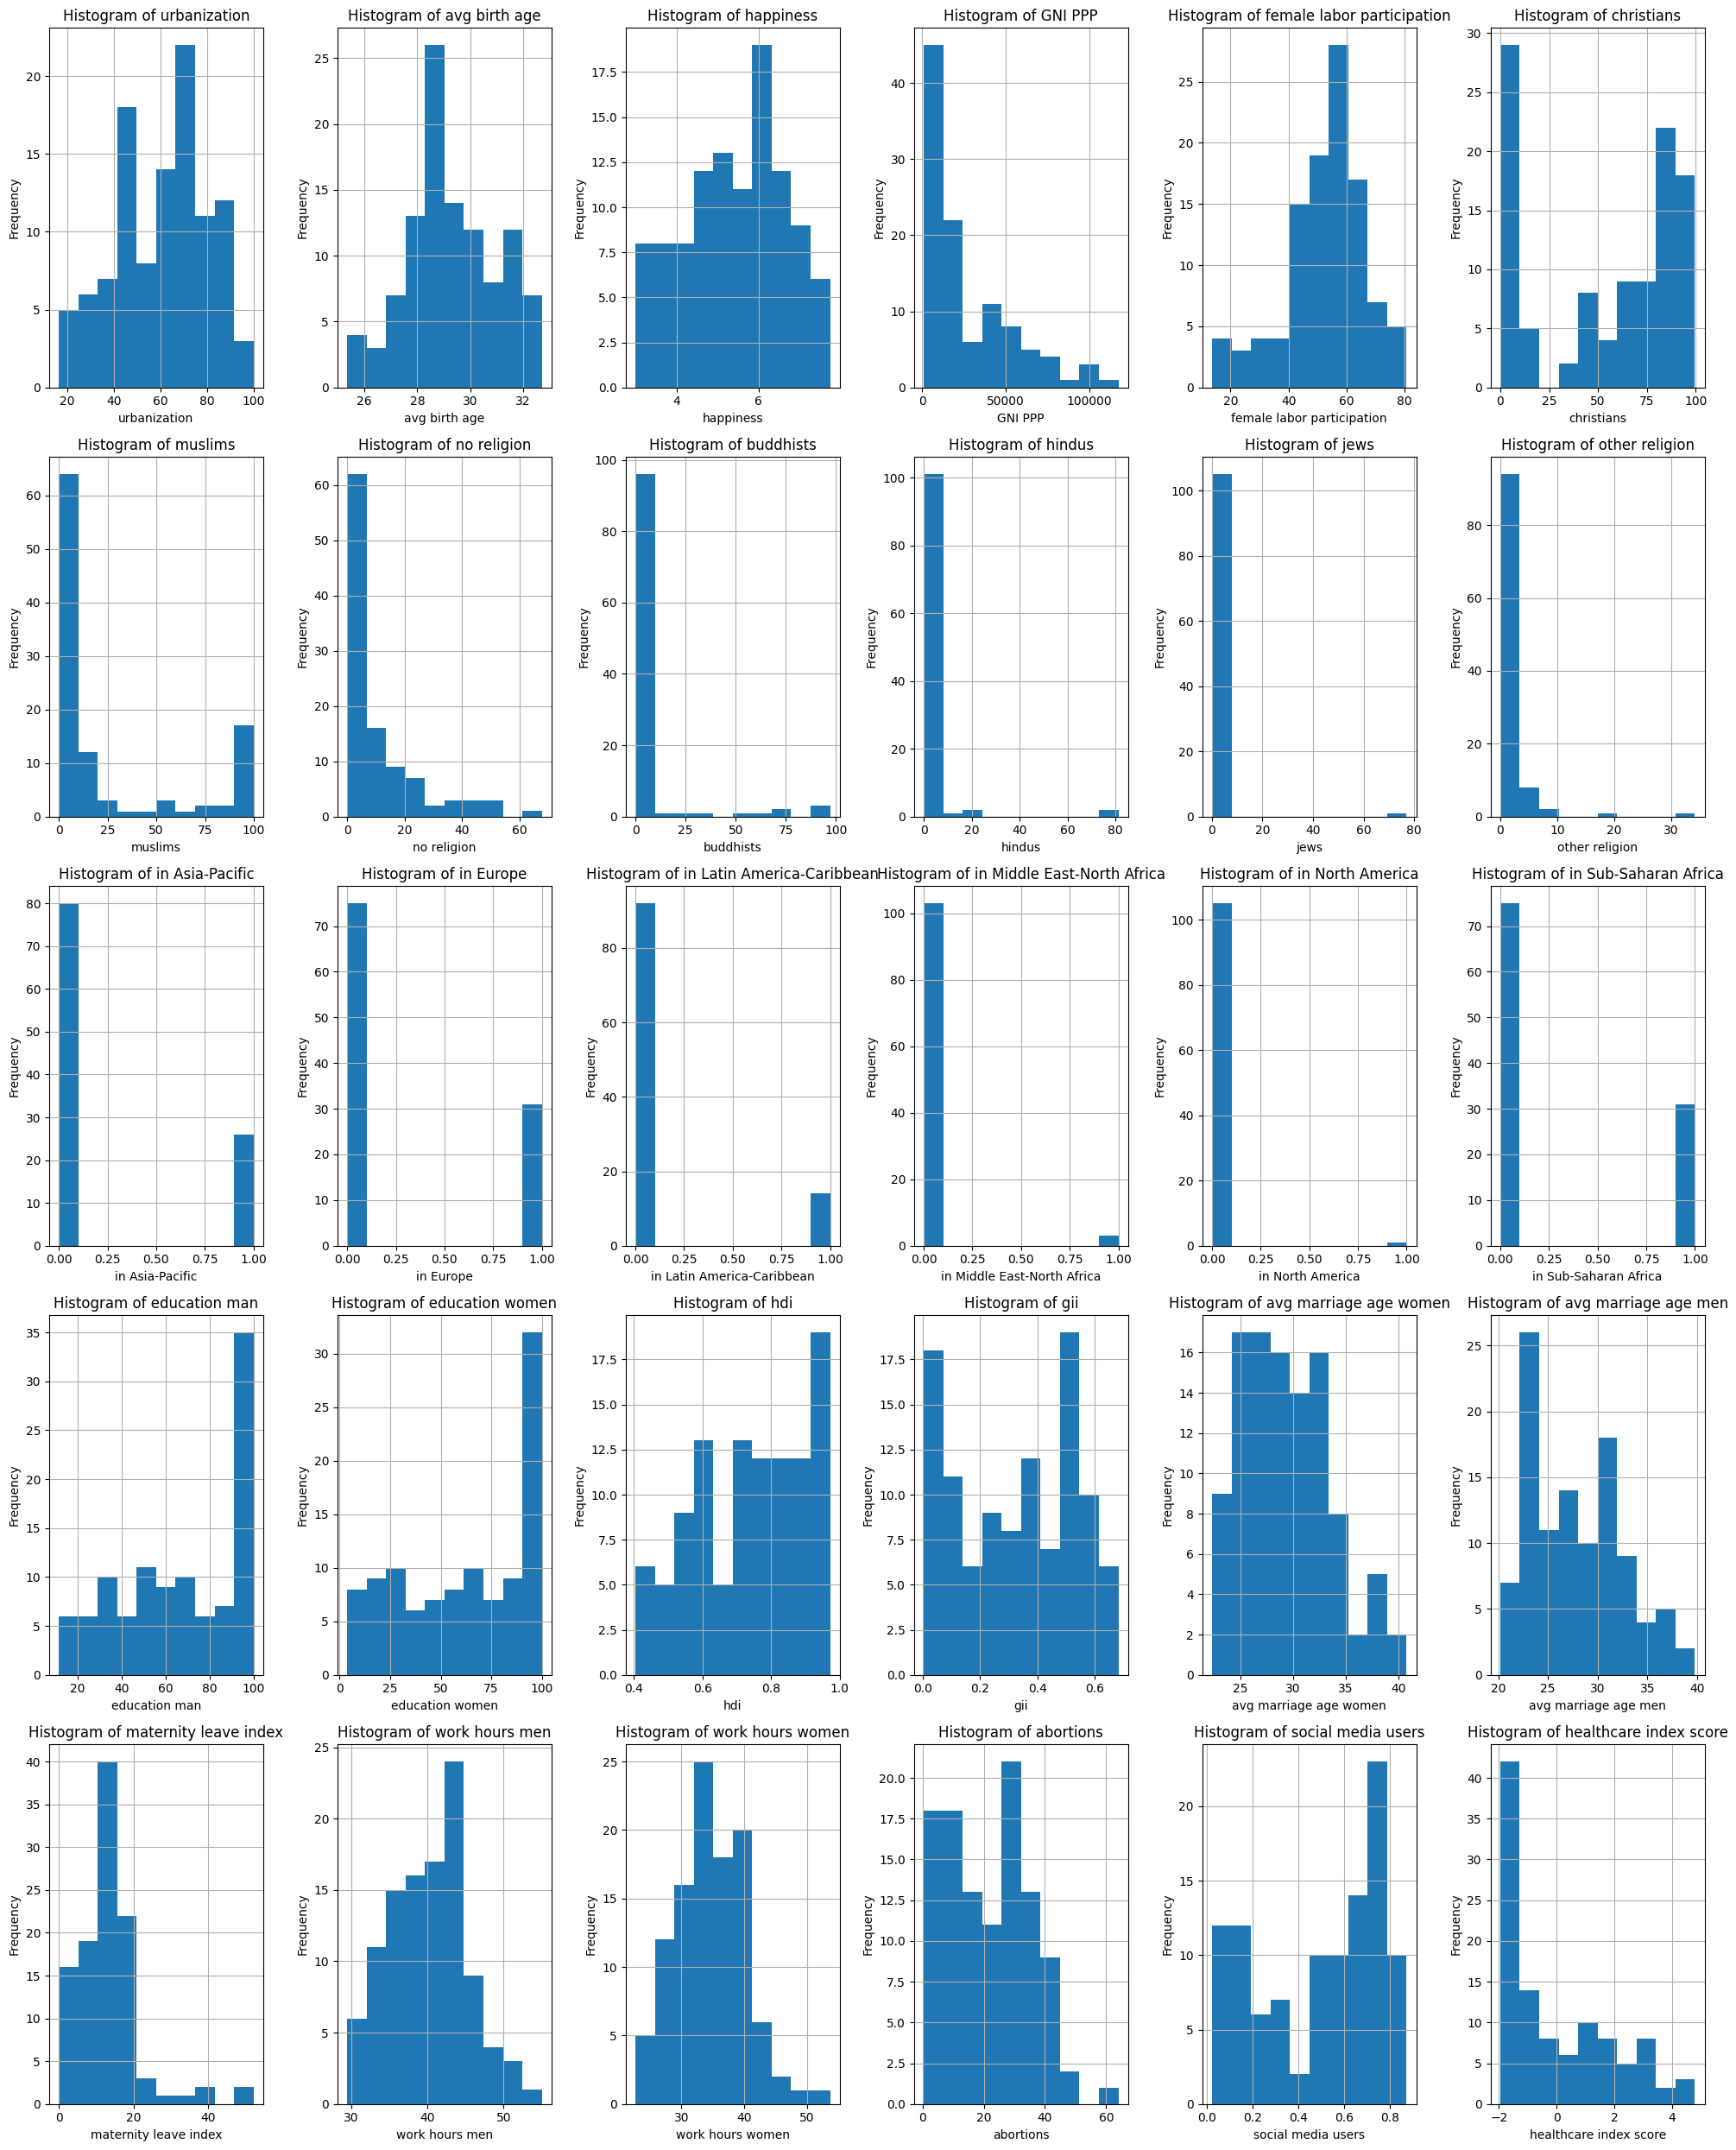

scaled features


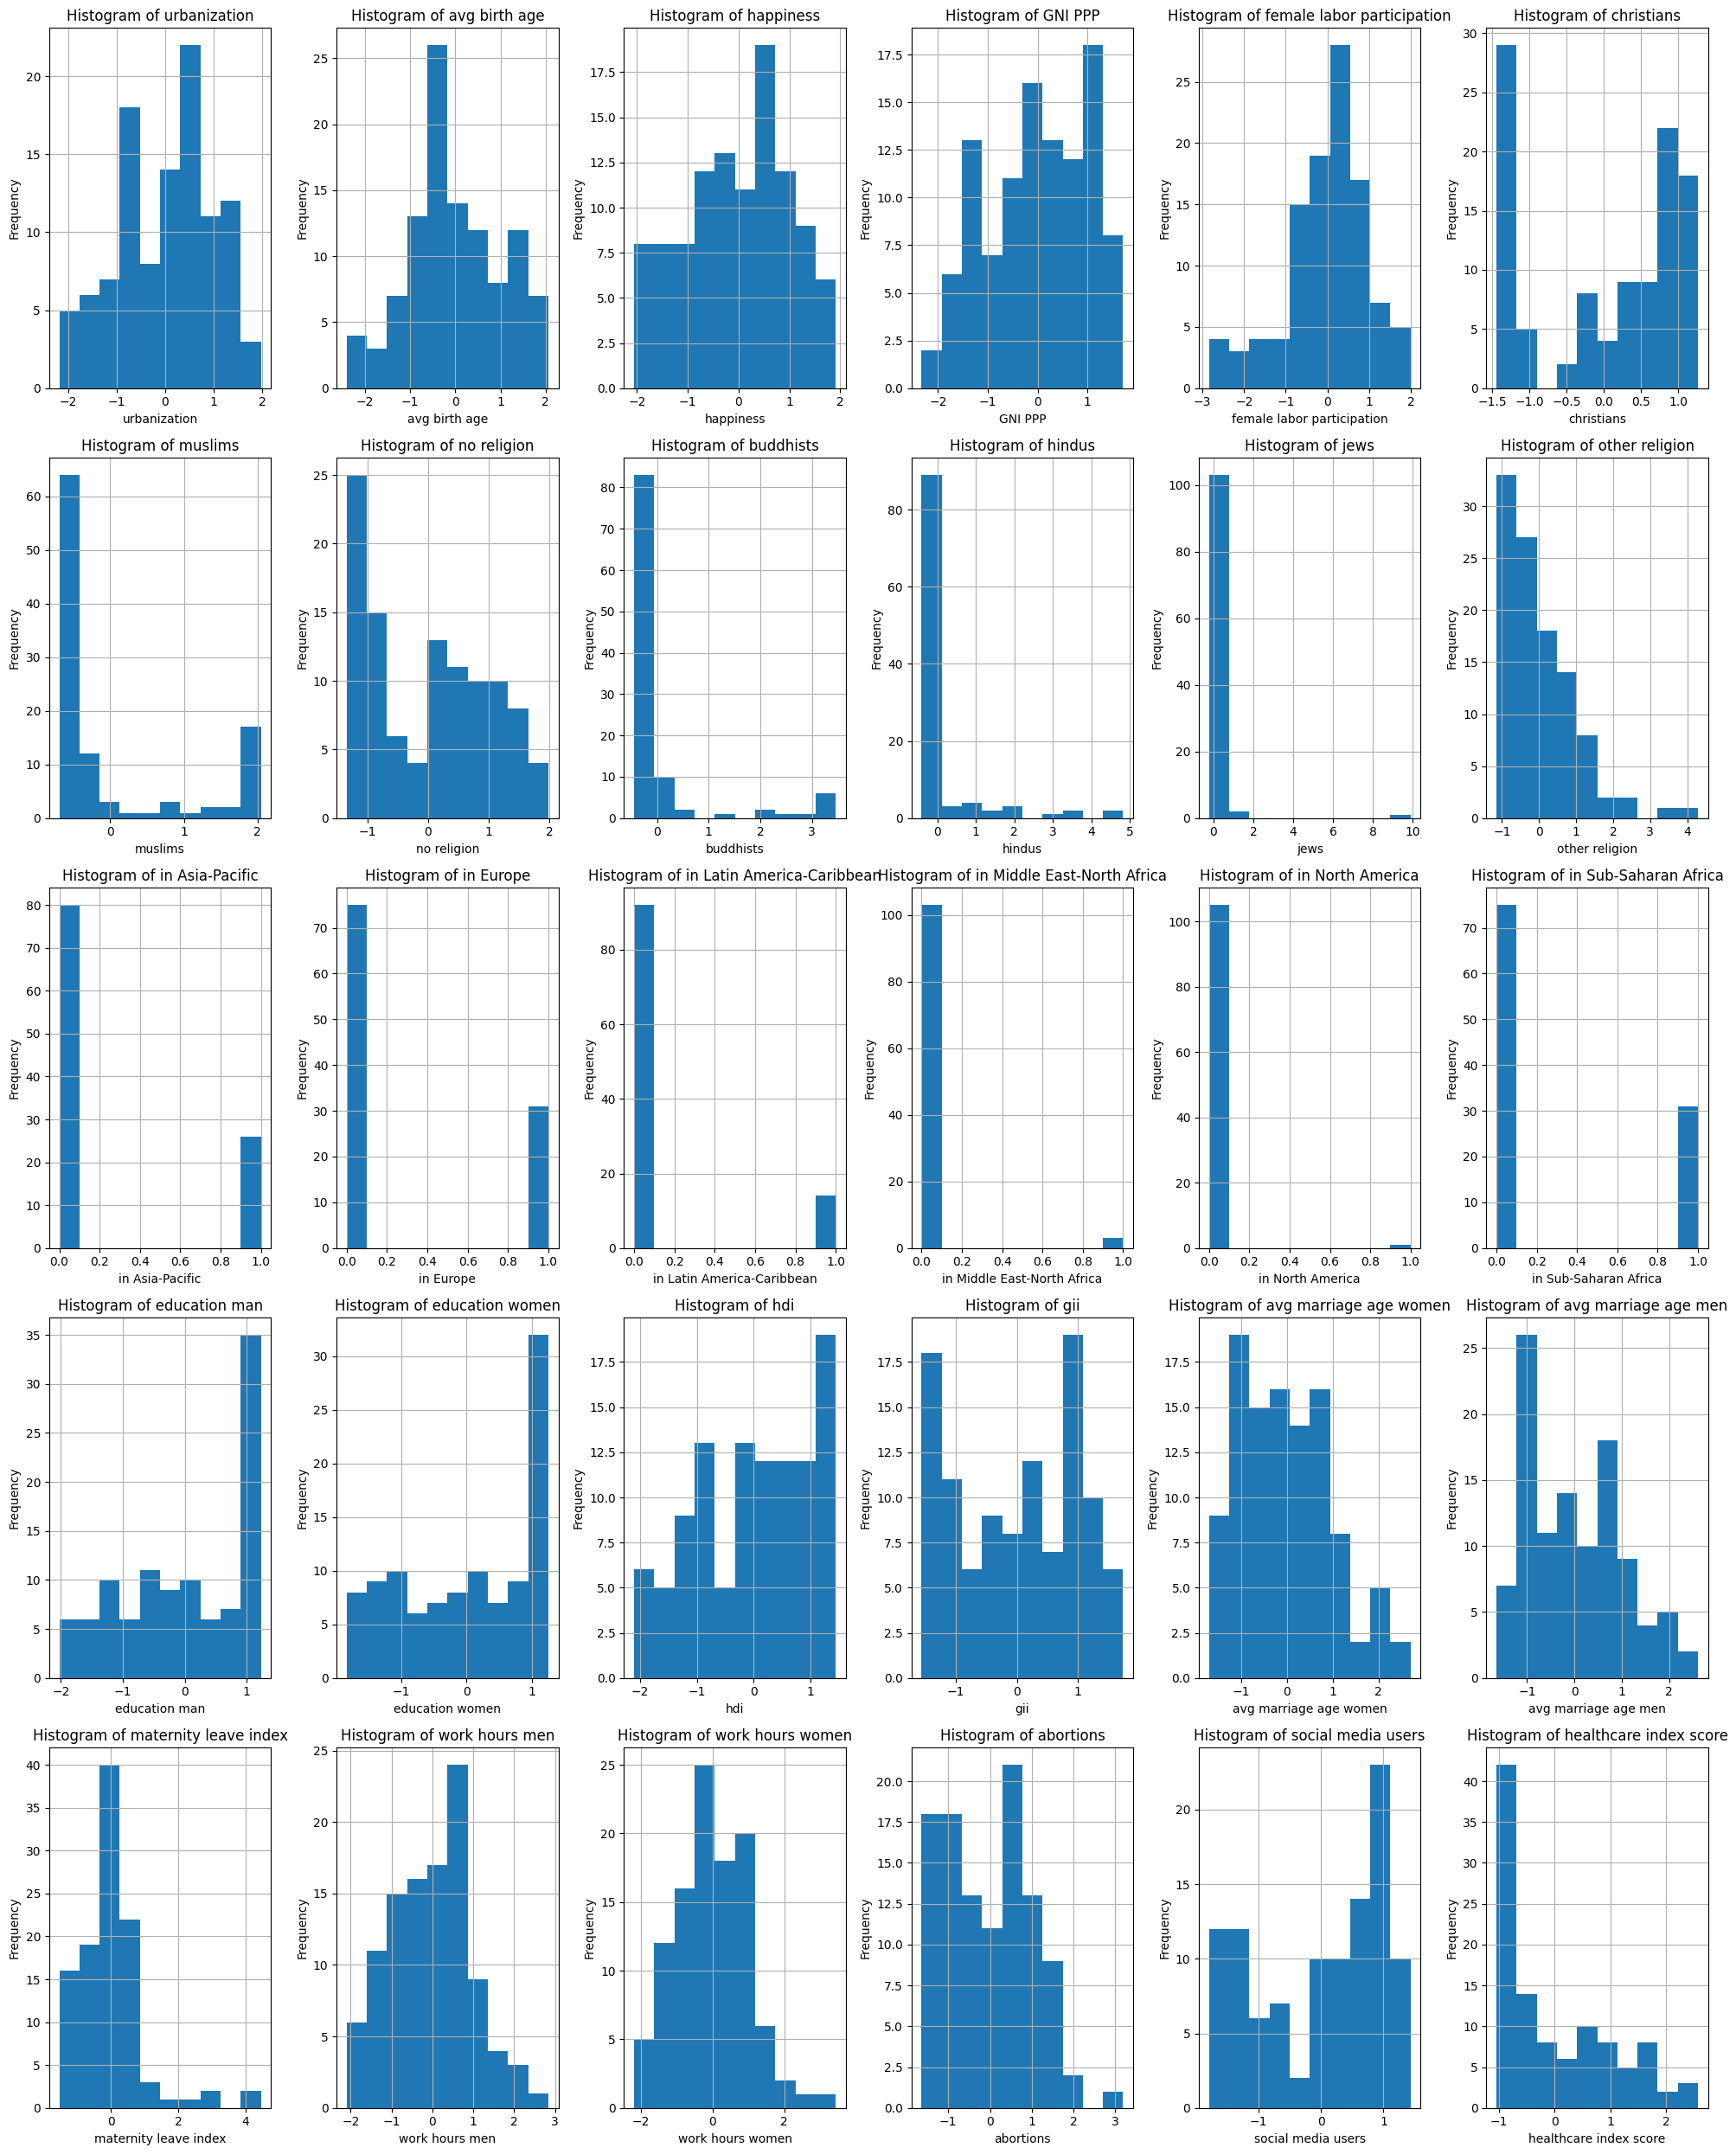

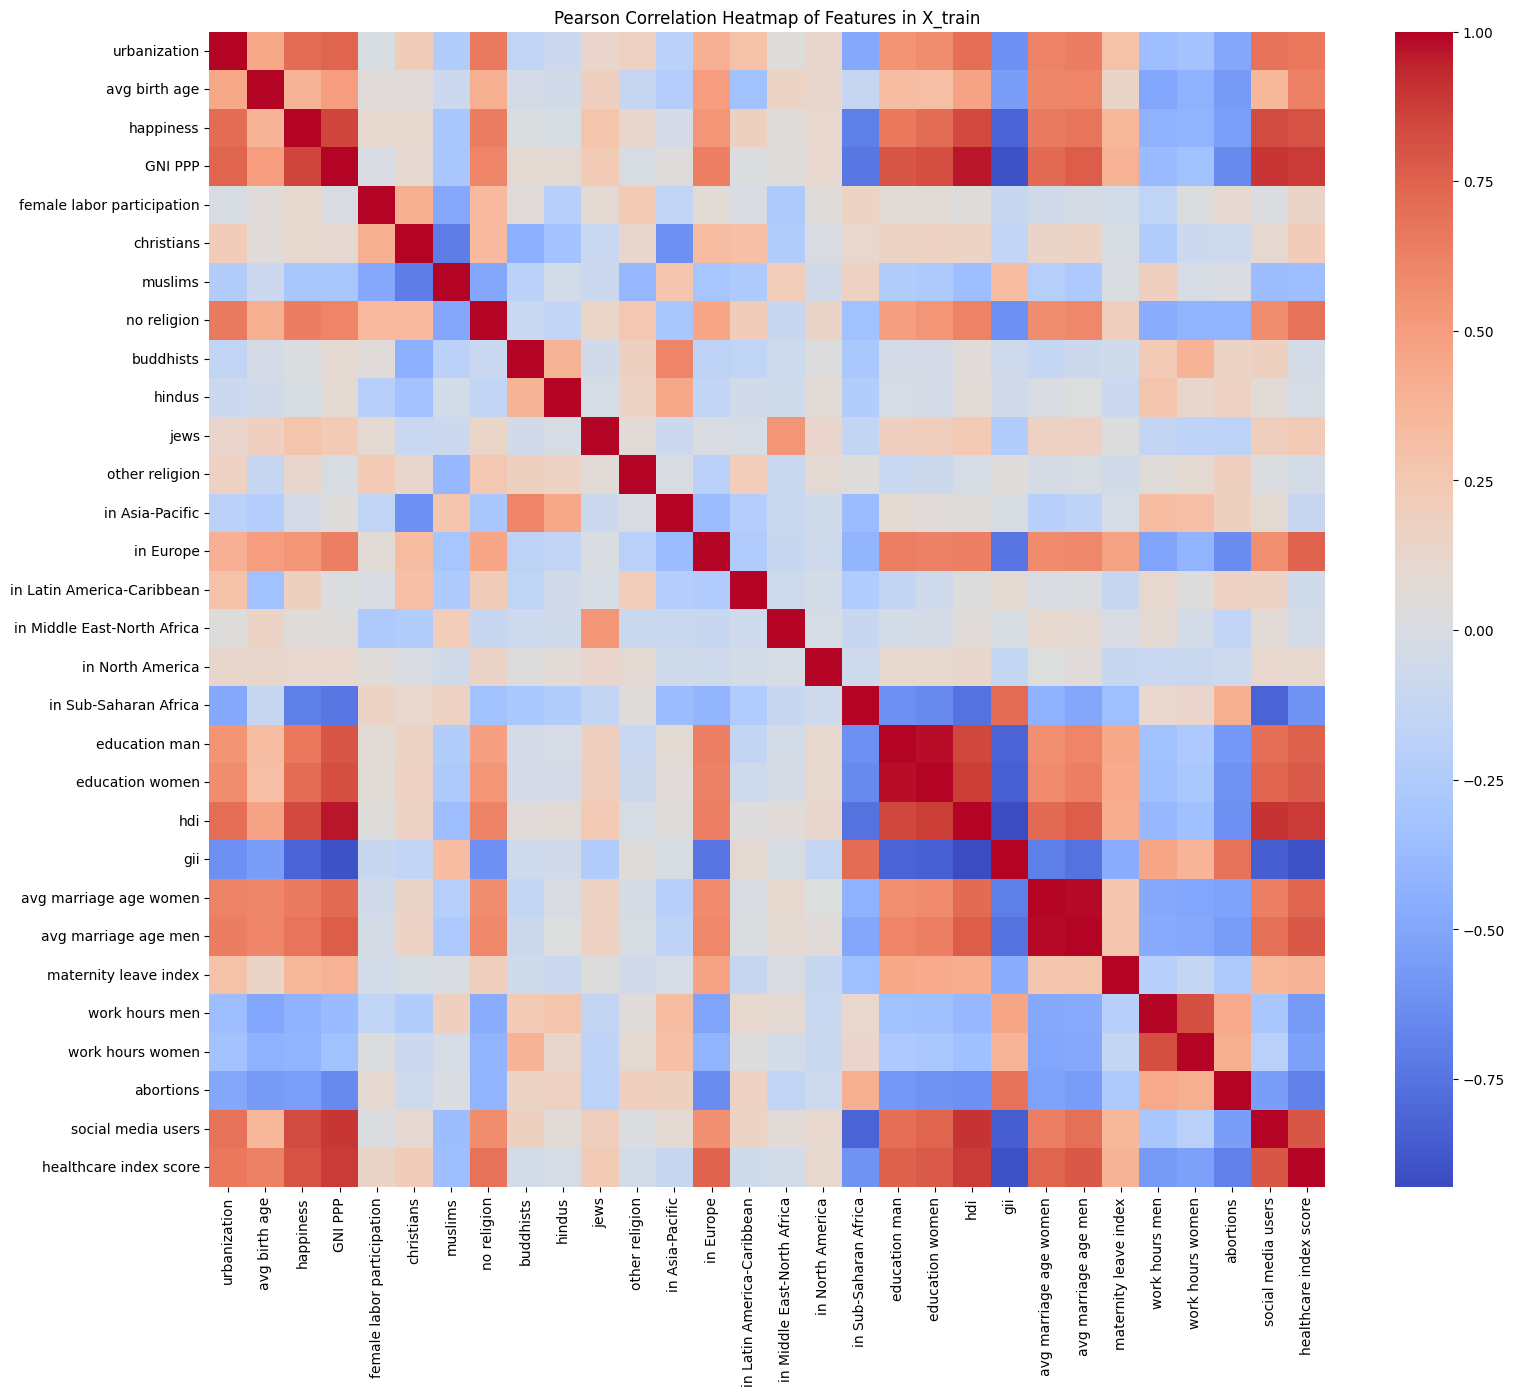


Top 5 most highly correlated pairs of features (absolute Pearson correlation):
  avg marriage age women and avg marriage age men: 0.9895
  education man and education women: 0.9805
  GNI PPP and hdi: 0.9682
  hdi and gii: -0.9295
  gii and healthcare index score: -0.9056


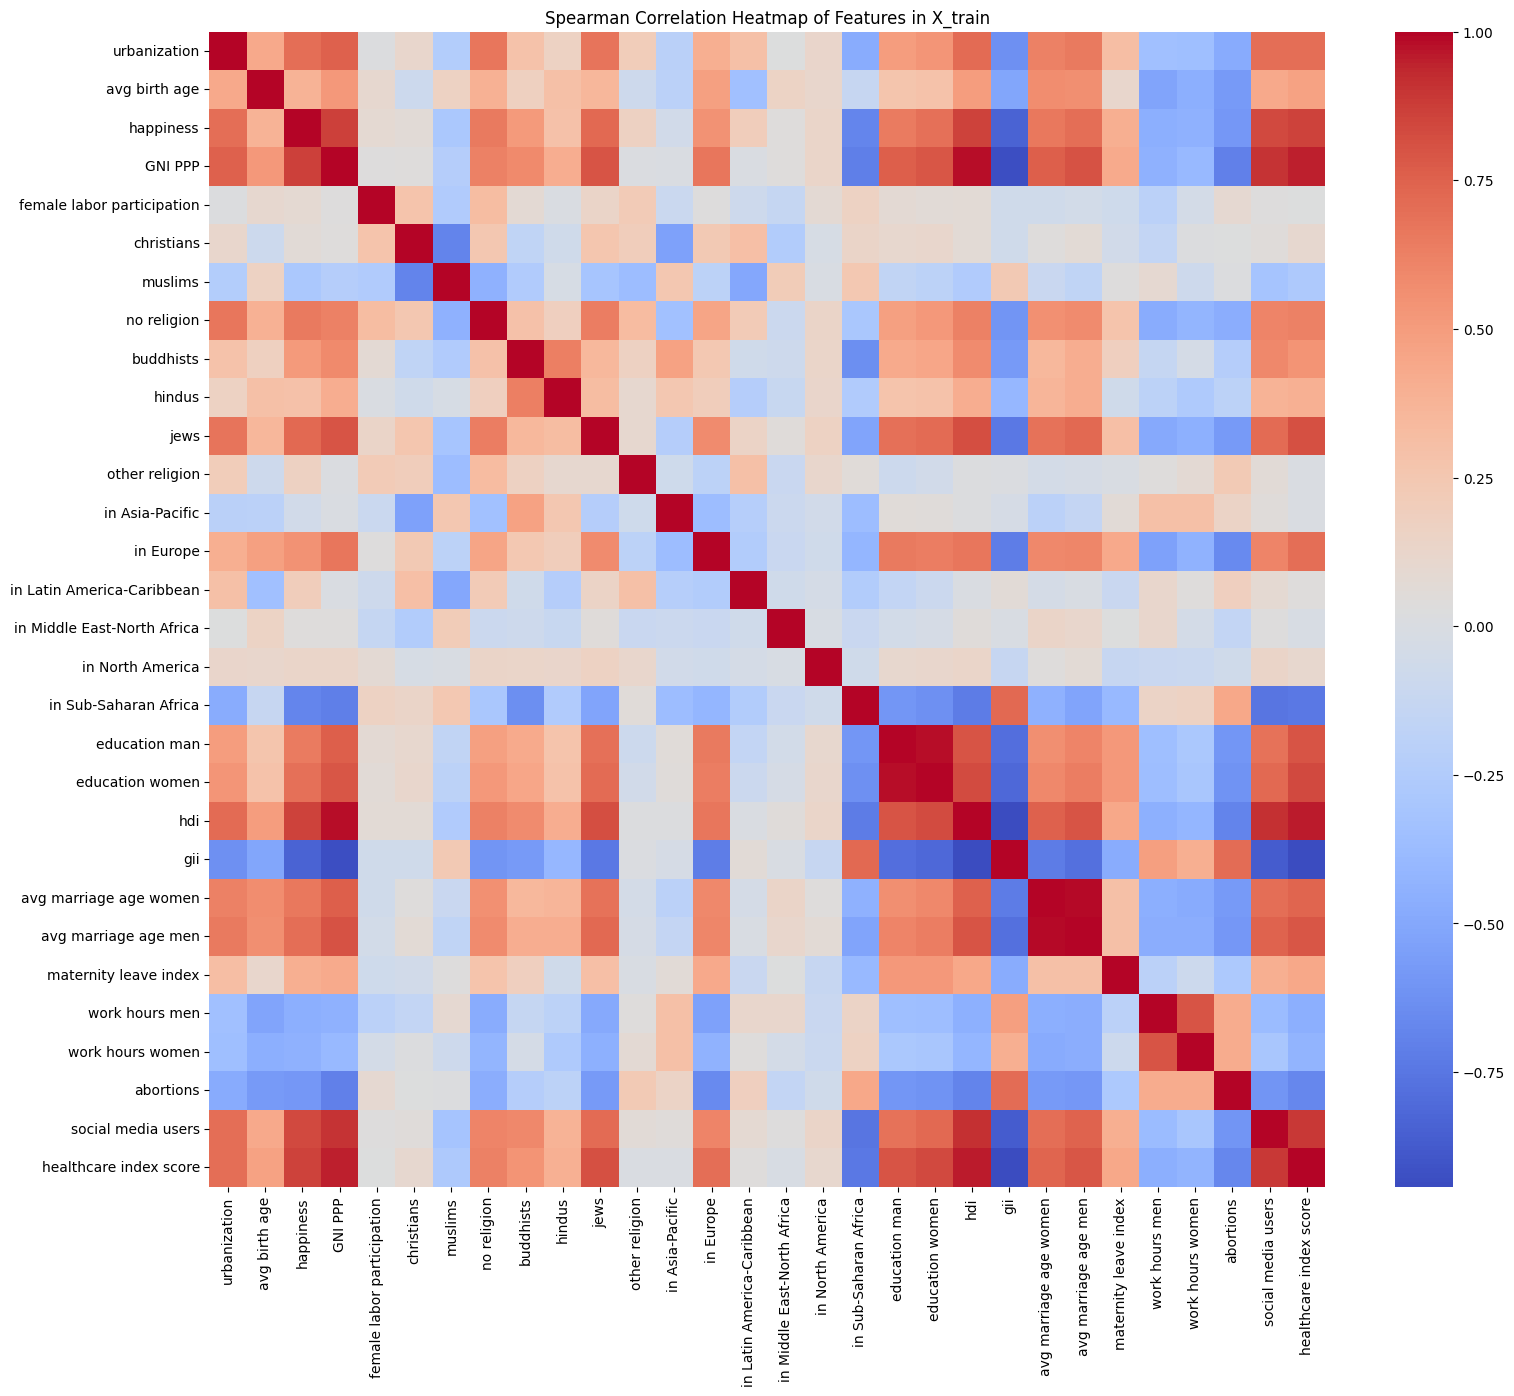


Top 5 most highly correlated pairs of features (absolute Spearman correlation):
  avg marriage age women and avg marriage age men: 0.9871
  education man and education women: 0.9820
  GNI PPP and hdi: 0.9781
  hdi and healthcare index score: 0.9605
  GNI PPP and healthcare index score: 0.9491


/tmp/ipython-input-1140664916.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_series.values, y=correlation_series.index, palette='coolwarm')


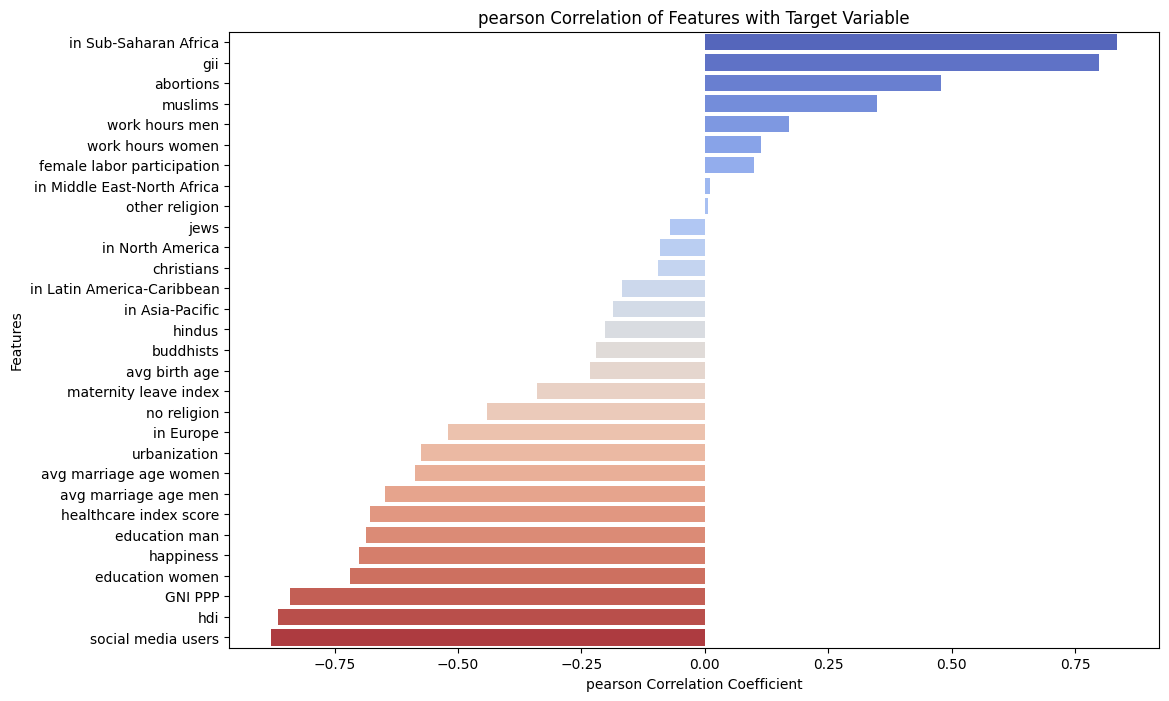


pearson Correlation with Target:
in Sub-Saharan Africa          0.834381
gii                            0.797438
abortions                      0.478885
muslims                        0.349747
work hours men                 0.170845
work hours women               0.114112
female labor participation     0.099885
in Middle East-North Africa    0.011170
other religion                 0.005654
jews                          -0.071159
in North America              -0.090590
christians                    -0.094503
in Latin America-Caribbean    -0.167194
in Asia-Pacific               -0.185259
hindus                        -0.202353
buddhists                     -0.220292
avg birth age                 -0.232213
maternity leave index         -0.339560
no religion                   -0.440683
in Europe                     -0.519533
urbanization                  -0.575595
avg marriage age women        -0.586678
avg marriage age men          -0.647425
healthcare index score        -0.677832
educat

/tmp/ipython-input-1140664916.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_series.values, y=correlation_series.index, palette='coolwarm')


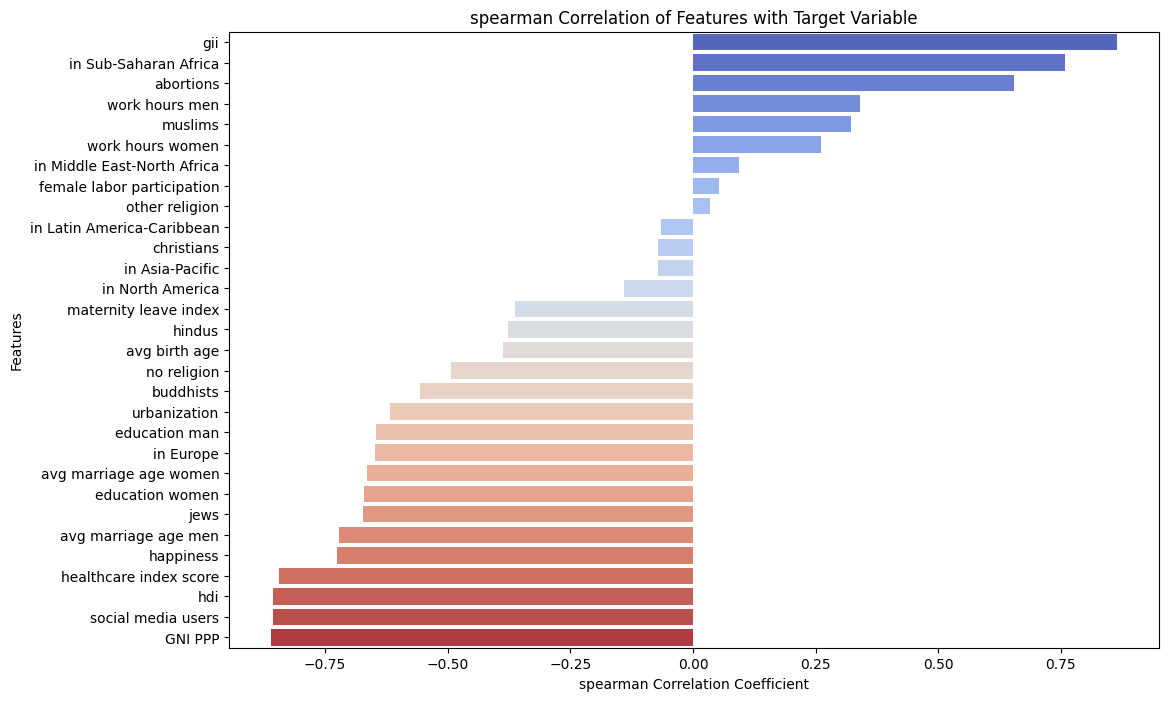


spearman Correlation with Target:
gii                            0.863911
in Sub-Saharan Africa          0.758841
abortions                      0.654204
work hours men                 0.341201
muslims                        0.322241
work hours women               0.260881
in Middle East-North Africa    0.093897
female labor participation     0.053731
other religion                 0.035053
in Latin America-Caribbean    -0.066026
christians                    -0.070489
in Asia-Pacific               -0.070590
in North America              -0.140345
maternity leave index         -0.362375
hindus                        -0.376686
avg birth age                 -0.387128
no religion                   -0.494177
buddhists                     -0.556041
urbanization                  -0.616775
education man                 -0.646761
in Europe                     -0.647336
avg marriage age women        -0.663912
education women               -0.669942
jews                          -0.672670
avg m

/tmp/ipython-input-2867624879.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mi_scores.values, y=mi_scores.index, palette='viridis')


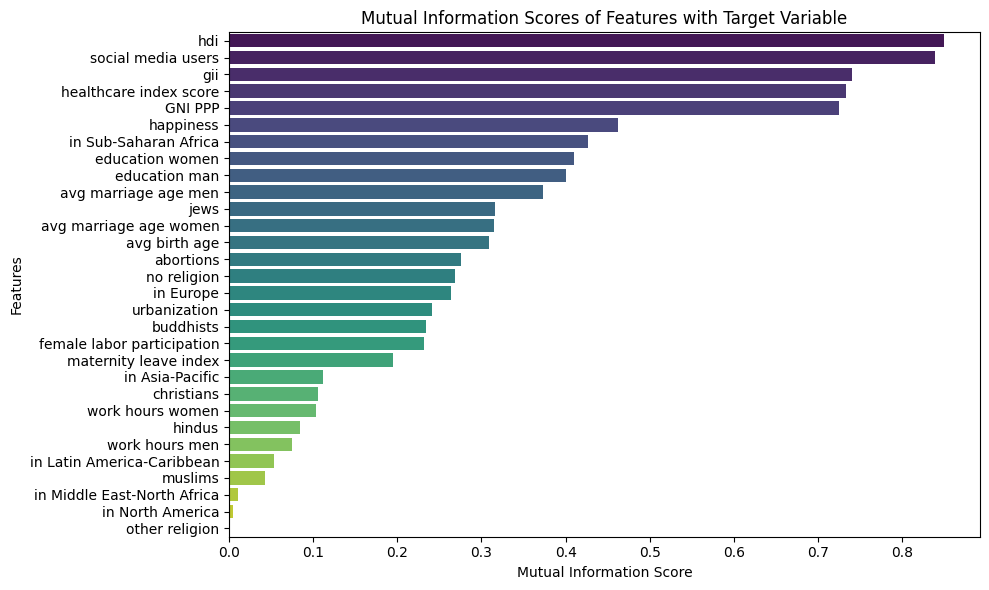

'\n#lasso regressor model\ngrid_search_result = gridsearch_loocv_lasso(scaled_train, y_train)\nprint("Best parameters found: ", grid_search_result.best_params_)\nprint("Best cross-validation score (negative MSE): ", grid_search_result.best_score_)\nbest_lasso_model = grid_search_result.best_estimator_\nprint("Coefficients of the best Lasso model:")\nfor feature, coef in zip(scaled_train.columns, best_lasso_model.coef_):\n    print(f"{feature}: {coef:.4f}")\n\n#elastic net regressor model\nelastic_net_grid_search_result = gridsearch_elastic_net_loocv(scaled_train, y_train)\nprint("Best parameters found for Elastic Net (LOOCV): ", elastic_net_grid_search_result.best_params_)\nprint("Best cross-validation score (negative MSE) for Elastic Net (LOOCV): ", elastic_net_grid_search_result.best_score_)\nbest_elastic_net_model = elastic_net_grid_search_result.best_estimator_\nprint("\nCoefficients of the best Elastic Net model (LOOCV):")\nfor feature, coef in zip(scaled_train.columns, best_elast

In [16]:
## 2023 data##
X_train, X_test, y_train, y_test = process_2023_data(init_process())

#feature distrebutions
unscaled_X_train,unscaled_X_test = create_health_index_score(X_train.copy(),X_test.copy())
print('unscaled features')
plot_features(unscaled_X_train)
scaled_train, scaled_test = scaling_2023(X_train, X_test)
print('scaled features')
plot_features(scaled_train)

#feature pairs correlations
feature_correlations(scaled_train, 'pearson')
feature_correlations(scaled_train, 'spearman')
#feature-target correlations and mutual information
analyze_target_correlation(scaled_train, y_train, 'pearson')
analyze_target_correlation(scaled_train, y_train, 'spearman')
analyze_mutual_information(scaled_train, y_train)
"""
#lasso regressor model
grid_search_result = gridsearch_loocv_lasso(scaled_train, y_train)
print("Best parameters found: ", grid_search_result.best_params_)
print("Best cross-validation score (negative MSE): ", grid_search_result.best_score_)
best_lasso_model = grid_search_result.best_estimator_
print("Coefficients of the best Lasso model:")
for feature, coef in zip(scaled_train.columns, best_lasso_model.coef_):
    print(f"{feature}: {coef:.4f}")

#elastic net regressor model
elastic_net_grid_search_result = gridsearch_elastic_net_loocv(scaled_train, y_train)
print("Best parameters found for Elastic Net (LOOCV): ", elastic_net_grid_search_result.best_params_)
print("Best cross-validation score (negative MSE) for Elastic Net (LOOCV): ", elastic_net_grid_search_result.best_score_)
best_elastic_net_model = elastic_net_grid_search_result.best_estimator_
print("\nCoefficients of the best Elastic Net model (LOOCV):")
for feature, coef in zip(scaled_train.columns, best_elastic_net_model.coef_):
    print(f"{feature}: {coef:.4f}")

#random forest regressor model
RF_grid_search_result = gridsearch_random_forest(scaled_train, y_train)
print("Best parameters found for Random Forest: (5 fold cv)", grid_search_result.best_params_)
print("Best cross-validation score (negative MSE) for Rnadom Forest: ", grid_search_result.best_score_)
"""

In [ ]:
def gridsearch_random_forest(X, y):
  rf_model = RandomForestRegressor(random_state=42)
  kf = KFold(n_splits=5,shuffle=True,random_state=42)

  param_grid = {
      'n_estimators': [25, 50, 100, 200 ,400],
      'max_depth': [2,3,4,5,None],
      'min_samples_split': [2,3,5,10,20],
      'min_samples_leaf': [1,2,3,5,8,15]
  }

  grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                                cv=kf, scoring='neg_mean_squared_error',
                                n_jobs=-1)

  grid_search_rf.fit(X, y)
  return grid_search_rf

In [ ]:
random_forest_result = gridsearch_random_forest(scaled_train, y_train)
print("Best parameters found for Random Forest: ", random_forest_result.best_params_)
print("Best cross-validation score (negative MSE) for Random Forest: ", random_forest_result.best_score_)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Assuming grid_search_rf, X_train, y_train, X_test, and y_test are already defined

# Get the best trained Random Forest model
best_rf_model = random_forest_result.best_estimator_

# --- Evaluate on Training Set ---
y_train_pred_rf = best_rf_model.predict(scaled_train)
mse_train_rf = mean_squared_error(y_train, y_train_pred_rf)
r2_train_rf = r2_score(y_train, y_train_pred_rf)

print(f"Training Set Performance:")
print(f"  Mean Squared Error: {mse_train_rf:.4f}")
print(f"  R-squared: {r2_train_rf:.4f}")

print("\n" + "="*50 + "\n")

# --- Evaluate on Test Set ---
y_test_pred_rf = best_rf_model.predict(scaled_test)
mse_test_rf = mean_squared_error(y_test, y_test_pred_rf)
r2_test_rf = r2_score(y_test, y_test_pred_rf)

print(f"Test Set Performance:")
print(f"  Mean Squared Error: {mse_test_rf:.4f}")
print(f"  R-squared: {r2_test_rf:.4f}")

print("\n" + "="*50 + "\n")

# --- Validation Set Performance (from Grid Search) ---
# The best_score_ from GridSearchCV is the mean cross-validation score (negative MSE)
validation_neg_mse = random_forest_result.best_score_
validation_mse = -validation_neg_mse # Convert negative MSE to positive MSE

print(f"Validation Set Performance (from Grid Search):")
print(f"  Mean Cross-Validation MSE: {validation_mse:.4f}")
# Note: R-squared is not directly available from best_score_ if MSE was the scoring metric
# You could calculate R-squared on the validation folds separately if needed.